In [348]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import StackingRegressor
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')

In [349]:
rooth_path = 'data/'
deng_sj_train = pd.read_csv(rooth_path + 'deng_sj_train.csv')
deng_iq_train = pd.read_csv(rooth_path + 'deng_iq_train.csv')
deng_sj_val = pd.read_csv(rooth_path + 'deng_sj_val.csv')
deng_iq_val = pd.read_csv(rooth_path + 'deng_iq_val.csv')
test_sj = pd.read_csv(rooth_path + 'test_sj_.csv')
test_iq = pd.read_csv(rooth_path + 'test_iq_.csv')

In [350]:
def pred_regressor(model, regressor, X_train, X_val, y_train, y_val, params):  
    
    #Grid Search
    grid_search = GridSearchCV(estimator=regressor, param_grid=params, cv=5, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_val)
    
    #Predictions
    predictions = {'y_pred' : np.expm1(y_pred)}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    print ("Test  MAE error :", mean_absolute_error(np.expm1(y_pred), np.expm1(y_val)))
    
    return grid_search.best_estimator_, df_predictions

In [351]:
# Random Forest Regressor
def rfr(X_train, X_val, y_train, y_val):
    
    model = 'Random Forest Regressor'
    regressor = RandomForestRegressor(random_state=42, n_jobs=-1)
    gs_params = {'n_estimators': [90,100,200,300], 'criterion': ['mae'], 'max_features': ['sqrt', 'auto', 'log2'],
                'min_samples_split' : [6,7,8,9,10], 'max_depth': [2,3,4]}

    regressor_rfr, pred_rfr = pred_regressor(model, regressor, X_train, X_val, y_train, y_val, params=gs_params)
    
    print('\nBest Parameters:\n',regressor_rfr)
    
    return regressor_rfr, pred_rfr

In [352]:
# Gradient Boosting Regressor
def gbr(X_train, X_val, y_train, y_val):
    
    model = 'Gradient Boosting Regressor'
    regressor = GradientBoostingRegressor(random_state=42, criterion='mae')
    gs_params = {'learning_rate': [0.01, 0.03, 0.1], 'n_estimators': [270, 300, 320],
                 'max_features': ['sqrt', 'auto'], 'min_samples_split' : [5,6,7], 'max_depth': [3,6,9]}

    regressor_gbr, pred_gbr = pred_regressor(model, regressor, X_train, X_val, y_train, y_val, params=gs_params)
    
    print('\nBest Parameters:\n',regressor_gbr)
    
    return regressor_gbr, pred_gbr

In [353]:
# Decision Tree
def dtr(X_train, X_val, y_train, y_val):
    
    model = 'Decision Tree Regressor'
    regressor = DecisionTreeRegressor(random_state=42)
    gs_params = { 'criterion': ['mae'], 'max_features': ['sqrt', 'auto'], 'min_samples_split' : [7,8,10,12], 
                 'max_depth': [3,5,7,10], 'criterion': ['mae']}

    regressor_dtr, pred_dtr = pred_regressor(model, regressor, X_train, X_val, y_train, y_val, params=gs_params)
    
    print('\nBest Parameters:\n',regressor_dtr)
    
    return regressor_dtr, pred_dtr

In [354]:
def xgb(X_train, X_val, y_train, y_val):
    
    model = XGBRegressor(max_depth=8, n_estimators=700, eta=0.3, subsample=0.9, alpha=0.8, min_child_weight=1, reg_lambda=1.8)

    model.fit(X_train, y_train, eval_metric = 'mae', eval_set=[(X_train, y_train), (X_val, y_val)])
    
    y_pred = model.predict(X_val)
    
    #Predictions
    predictions = {'y_pred' : np.expm1(y_pred)}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    print ("Test  MAE error :", mean_absolute_error(np.expm1(y_pred), np.expm1(y_val)))
    
    return model, df_predictions

### San Juan

In [355]:
X_train_sj = deng_sj_train.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_train_sj = deng_sj_train['total_cases']
X_val_sj = deng_sj_val.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_val_sj = deng_sj_val['total_cases']
X_test_sj = test_sj.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear'])

In [356]:
scaler = RobustScaler()
X_train_sj = scaler.fit_transform(X_train_sj)
X_val_sj = scaler.transform(X_val_sj)

In [88]:
# Random Forest Regressor
regressor_rfr_sj, pred_rfr_sj = rfr(X_train_sj, X_val_sj, y_train_sj, y_val_sj)

Test  MAE error : 20.533292906077293

Best Parameters:
 RandomForestRegressor(criterion='mae', max_depth=2, min_samples_split=7,
                      n_estimators=200, n_jobs=-1, random_state=42)


In [89]:
# Gradient Boosting Regressor
regressor_gbr_sj, pred_gbr_sj = gbr(X_train_sj, X_val_sj, y_train_sj, y_val_sj)

Test  MAE error : 15.80576876344294

Best Parameters:
 GradientBoostingRegressor(criterion='mae', learning_rate=0.01,
                          max_features='sqrt', min_samples_split=6,
                          n_estimators=270, random_state=42)


In [90]:
# Decision Tree Regressor
regressor_dtr_sj, pred_dtr_sj = dtr(X_train_sj, X_val_sj, y_train_sj, y_val_sj)

Test  MAE error : 19.520333031632642

Best Parameters:
 DecisionTreeRegressor(criterion='mae', max_depth=3, max_features='auto',
                      min_samples_split=7, random_state=42)


In [213]:
# XGBoost Regressor
model_xgb_sj, pred_xgb_sj = xgb(X_train_sj, X_val_sj, y_train_sj, y_val_sj)

[0]	validation_0-mae:1.80782	validation_1-mae:1.60727
[1]	validation_0-mae:1.31190	validation_1-mae:1.18699
[2]	validation_0-mae:0.96274	validation_1-mae:0.93272
[3]	validation_0-mae:0.72031	validation_1-mae:0.87897
[4]	validation_0-mae:0.55007	validation_1-mae:0.84807
[5]	validation_0-mae:0.43328	validation_1-mae:0.80609
[6]	validation_0-mae:0.35374	validation_1-mae:0.77244
[7]	validation_0-mae:0.29718	validation_1-mae:0.74664
[8]	validation_0-mae:0.25495	validation_1-mae:0.74174
[9]	validation_0-mae:0.22183	validation_1-mae:0.74440
[10]	validation_0-mae:0.19163	validation_1-mae:0.74195
[11]	validation_0-mae:0.16647	validation_1-mae:0.73616
[12]	validation_0-mae:0.15067	validation_1-mae:0.72950
[13]	validation_0-mae:0.13755	validation_1-mae:0.72957
[14]	validation_0-mae:0.12409	validation_1-mae:0.72475
[15]	validation_0-mae:0.11256	validation_1-mae:0.71979
[16]	validation_0-mae:0.10358	validation_1-mae:0.71537
[17]	validation_0-mae:0.09458	validation_1-mae:0.71937
[18]	validation_0-ma

[149]	validation_0-mae:0.01715	validation_1-mae:0.72384
[150]	validation_0-mae:0.01709	validation_1-mae:0.72381
[151]	validation_0-mae:0.01697	validation_1-mae:0.72380
[152]	validation_0-mae:0.01686	validation_1-mae:0.72370
[153]	validation_0-mae:0.01686	validation_1-mae:0.72370
[154]	validation_0-mae:0.01686	validation_1-mae:0.72370
[155]	validation_0-mae:0.01681	validation_1-mae:0.72373
[156]	validation_0-mae:0.01673	validation_1-mae:0.72377
[157]	validation_0-mae:0.01673	validation_1-mae:0.72377
[158]	validation_0-mae:0.01673	validation_1-mae:0.72377
[159]	validation_0-mae:0.01673	validation_1-mae:0.72377
[160]	validation_0-mae:0.01673	validation_1-mae:0.72377
[161]	validation_0-mae:0.01673	validation_1-mae:0.72377
[162]	validation_0-mae:0.01673	validation_1-mae:0.72377
[163]	validation_0-mae:0.01673	validation_1-mae:0.72377
[164]	validation_0-mae:0.01673	validation_1-mae:0.72377
[165]	validation_0-mae:0.01673	validation_1-mae:0.72377
[166]	validation_0-mae:0.01673	validation_1-mae:

[296]	validation_0-mae:0.01562	validation_1-mae:0.72368
[297]	validation_0-mae:0.01562	validation_1-mae:0.72368
[298]	validation_0-mae:0.01562	validation_1-mae:0.72368
[299]	validation_0-mae:0.01562	validation_1-mae:0.72368
[300]	validation_0-mae:0.01562	validation_1-mae:0.72368
[301]	validation_0-mae:0.01562	validation_1-mae:0.72368
[302]	validation_0-mae:0.01562	validation_1-mae:0.72368
[303]	validation_0-mae:0.01562	validation_1-mae:0.72368
[304]	validation_0-mae:0.01562	validation_1-mae:0.72368
[305]	validation_0-mae:0.01562	validation_1-mae:0.72368
[306]	validation_0-mae:0.01562	validation_1-mae:0.72368
[307]	validation_0-mae:0.01562	validation_1-mae:0.72368
[308]	validation_0-mae:0.01562	validation_1-mae:0.72368
[309]	validation_0-mae:0.01562	validation_1-mae:0.72368
[310]	validation_0-mae:0.01562	validation_1-mae:0.72368
[311]	validation_0-mae:0.01562	validation_1-mae:0.72368
[312]	validation_0-mae:0.01562	validation_1-mae:0.72368
[313]	validation_0-mae:0.01562	validation_1-mae:

[443]	validation_0-mae:0.01513	validation_1-mae:0.72335
[444]	validation_0-mae:0.01513	validation_1-mae:0.72335
[445]	validation_0-mae:0.01506	validation_1-mae:0.72334
[446]	validation_0-mae:0.01506	validation_1-mae:0.72334
[447]	validation_0-mae:0.01506	validation_1-mae:0.72334
[448]	validation_0-mae:0.01506	validation_1-mae:0.72334
[449]	validation_0-mae:0.01506	validation_1-mae:0.72334
[450]	validation_0-mae:0.01506	validation_1-mae:0.72334
[451]	validation_0-mae:0.01506	validation_1-mae:0.72334
[452]	validation_0-mae:0.01506	validation_1-mae:0.72334
[453]	validation_0-mae:0.01506	validation_1-mae:0.72334
[454]	validation_0-mae:0.01506	validation_1-mae:0.72334
[455]	validation_0-mae:0.01506	validation_1-mae:0.72334
[456]	validation_0-mae:0.01506	validation_1-mae:0.72334
[457]	validation_0-mae:0.01506	validation_1-mae:0.72334
[458]	validation_0-mae:0.01506	validation_1-mae:0.72334
[459]	validation_0-mae:0.01506	validation_1-mae:0.72334
[460]	validation_0-mae:0.01506	validation_1-mae:

[590]	validation_0-mae:0.01449	validation_1-mae:0.72322
[591]	validation_0-mae:0.01449	validation_1-mae:0.72322
[592]	validation_0-mae:0.01449	validation_1-mae:0.72322
[593]	validation_0-mae:0.01449	validation_1-mae:0.72322
[594]	validation_0-mae:0.01449	validation_1-mae:0.72322
[595]	validation_0-mae:0.01449	validation_1-mae:0.72322
[596]	validation_0-mae:0.01449	validation_1-mae:0.72322
[597]	validation_0-mae:0.01449	validation_1-mae:0.72322
[598]	validation_0-mae:0.01449	validation_1-mae:0.72322
[599]	validation_0-mae:0.01449	validation_1-mae:0.72322
[600]	validation_0-mae:0.01449	validation_1-mae:0.72322
[601]	validation_0-mae:0.01446	validation_1-mae:0.72312
[602]	validation_0-mae:0.01446	validation_1-mae:0.72312
[603]	validation_0-mae:0.01446	validation_1-mae:0.72312
[604]	validation_0-mae:0.01446	validation_1-mae:0.72312
[605]	validation_0-mae:0.01446	validation_1-mae:0.72312
[606]	validation_0-mae:0.01446	validation_1-mae:0.72312
[607]	validation_0-mae:0.01446	validation_1-mae:

#### Concatenate X_train and X_val, train again and predict in X_test for San Juan

In [357]:
X_train_sj_all = pd.concat([deng_sj_train, deng_sj_val])
y_train_sj_all = pd.concat([y_train_sj, y_val_sj])

In [358]:
X_train_sj_all = X_train_sj_all.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])

In [360]:
# Fix skewness on Test Set
numeric_feats = X_test_sj.columns[4:-5]

# Check the skew of all numerical features
skewed_feats = X_test_sj[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


Skew in numerical features: 



,Skew
reanalysis_precip_amt_kg_per_m2_var,5.927053
ndvi_nw_var,4.933539
reanalysis_precip_amt_kg_per_m2,4.797071
reanalysis_precip_amt_kg_per_m2_sum,3.392701
reanalysis_precip_amt_kg_per_m2_av,3.392701
reanalysis_min_air_temp_c_var,3.344853
station_precip_mm_var,3.178101
precipitation_amt_mm_var,2.958211
ndvi_ne_var,2.476789
reanalysis_max_air_temp_c_var,2.370058


In [361]:
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    X_test_sj[feat] = boxcox1p(X_test_sj[feat], lam)
X_test_sj.fillna(method='ffill', inplace=True)

In [362]:
scaler = RobustScaler()
X_train_sj_all = scaler.fit_transform(X_train_sj_all)
X_test_sj = scaler.transform(X_test_sj)

#### Final Model for San Juan

In [376]:
#Stacking
stacked_predictions_sj = StackingRegressor(estimators=
        [('Random Forest Regressor', RandomForestRegressor(criterion='mae', max_depth=2, min_samples_split=7,
                      n_estimators=200, n_jobs=-1, random_state=42)),
         ('Gradient Boosting Regressor', GradientBoostingRegressor(criterion='mae', learning_rate=0.01,
                          max_features='sqrt', min_samples_split=6,
                          n_estimators=270, random_state=42)), 
         ('XGBoost',XGBRegressor(max_depth=8, n_estimators=700, eta=0.3, subsample=0.9, alpha=0.8, min_child_weight=1, reg_lambda=1.8),
         ('LassoRegression', Lasso()))])
final_predictions_sj = stacked_predictions_sj.fit(X_train_sj_all, y_train_sj_all).predict(X_test_sj)
predictions_sj = pd.DataFrame(np.expm1(final_predictions_sj))

In [380]:
gbr_prediction_sj = regressor_gbr_sj.fit(X_train_sj_all, y_train_sj_all).predict(X_test_sj)

### Iquitos

In [365]:
X_train_iq = deng_iq_train.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_train_iq = deng_iq_train['total_cases']
X_val_iq = deng_iq_val.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])
y_val_iq = deng_iq_val['total_cases']
X_test_iq = test_iq.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear'])

In [366]:
scaler = RobustScaler()
X_train_iq = scaler.fit_transform(X_train_iq)
X_val_iq = scaler.transform(X_val_iq)

In [22]:
# Random Forest Regressor
regressor_rfr_iq, pred_rfr_iq = rfr(X_train_iq, X_val_iq, y_train_iq, y_val_iq)

Test  MAE error : 3.5200797966821544

Best Parameters:
 RandomForestRegressor(criterion='mae', max_depth=3, max_features='log2',
                      min_samples_split=7, n_jobs=-1, random_state=42)


In [24]:
# Gradient Boosting Regressor
regressor_gbr_iq, pred_gbr_iq = gbr(X_train_iq, X_val_iq, y_train_iq, y_val_iq)

Test  MAE error : 4.13339817243151

Best Parameters:
 GradientBoostingRegressor(criterion='mae', learning_rate=0.01, max_depth=9,
                          max_features='sqrt', min_samples_split=5,
                          n_estimators=250, random_state=42)


In [26]:
# Decision Tree Regressor
regressor_dtr_iq, pred_dtr_iq = dtr(X_train_iq, X_val_iq, y_train_iq, y_val_iq)

Test  MAE error : 3.814814814814815

Best Parameters:
 DecisionTreeRegressor(criterion='mae', max_depth=3, max_features='sqrt',
                      min_samples_split=7, random_state=42)


In [219]:
# XGBoost Regressor
model_xgb_iq, pred_xgb_iq = xgb(X_train_iq, X_val_iq, y_train_iq, y_val_iq)

[0]	validation_0-mae:0.97005	validation_1-mae:1.01354
[1]	validation_0-mae:0.74863	validation_1-mae:0.98214
[2]	validation_0-mae:0.58406	validation_1-mae:0.87788
[3]	validation_0-mae:0.46885	validation_1-mae:0.86391
[4]	validation_0-mae:0.38194	validation_1-mae:0.86612
[5]	validation_0-mae:0.32027	validation_1-mae:0.85163
[6]	validation_0-mae:0.27021	validation_1-mae:0.87553
[7]	validation_0-mae:0.22430	validation_1-mae:0.89103
[8]	validation_0-mae:0.19640	validation_1-mae:0.89131
[9]	validation_0-mae:0.17479	validation_1-mae:0.89931
[10]	validation_0-mae:0.15255	validation_1-mae:0.89932
[11]	validation_0-mae:0.13753	validation_1-mae:0.90191
[12]	validation_0-mae:0.12356	validation_1-mae:0.90067
[13]	validation_0-mae:0.11068	validation_1-mae:0.90331
[14]	validation_0-mae:0.10129	validation_1-mae:0.90370
[15]	validation_0-mae:0.09219	validation_1-mae:0.90711
[16]	validation_0-mae:0.08532	validation_1-mae:0.90467
[17]	validation_0-mae:0.07788	validation_1-mae:0.90629
[18]	validation_0-ma

[149]	validation_0-mae:0.02032	validation_1-mae:0.91633
[150]	validation_0-mae:0.02032	validation_1-mae:0.91633
[151]	validation_0-mae:0.02032	validation_1-mae:0.91633
[152]	validation_0-mae:0.02019	validation_1-mae:0.91641
[153]	validation_0-mae:0.02019	validation_1-mae:0.91641
[154]	validation_0-mae:0.02019	validation_1-mae:0.91641
[155]	validation_0-mae:0.01997	validation_1-mae:0.91641
[156]	validation_0-mae:0.01997	validation_1-mae:0.91641
[157]	validation_0-mae:0.01997	validation_1-mae:0.91641
[158]	validation_0-mae:0.01997	validation_1-mae:0.91641
[159]	validation_0-mae:0.01997	validation_1-mae:0.91641
[160]	validation_0-mae:0.01997	validation_1-mae:0.91641
[161]	validation_0-mae:0.01997	validation_1-mae:0.91641
[162]	validation_0-mae:0.01997	validation_1-mae:0.91641
[163]	validation_0-mae:0.01997	validation_1-mae:0.91641
[164]	validation_0-mae:0.01997	validation_1-mae:0.91641
[165]	validation_0-mae:0.01981	validation_1-mae:0.91623
[166]	validation_0-mae:0.01981	validation_1-mae:

[296]	validation_0-mae:0.01803	validation_1-mae:0.91641
[297]	validation_0-mae:0.01803	validation_1-mae:0.91641
[298]	validation_0-mae:0.01803	validation_1-mae:0.91641
[299]	validation_0-mae:0.01803	validation_1-mae:0.91641
[300]	validation_0-mae:0.01803	validation_1-mae:0.91641
[301]	validation_0-mae:0.01803	validation_1-mae:0.91641
[302]	validation_0-mae:0.01803	validation_1-mae:0.91641
[303]	validation_0-mae:0.01803	validation_1-mae:0.91641
[304]	validation_0-mae:0.01803	validation_1-mae:0.91641
[305]	validation_0-mae:0.01803	validation_1-mae:0.91641
[306]	validation_0-mae:0.01803	validation_1-mae:0.91641
[307]	validation_0-mae:0.01803	validation_1-mae:0.91641
[308]	validation_0-mae:0.01803	validation_1-mae:0.91641
[309]	validation_0-mae:0.01803	validation_1-mae:0.91641
[310]	validation_0-mae:0.01803	validation_1-mae:0.91641
[311]	validation_0-mae:0.01803	validation_1-mae:0.91641
[312]	validation_0-mae:0.01803	validation_1-mae:0.91641
[313]	validation_0-mae:0.01803	validation_1-mae:

[443]	validation_0-mae:0.01738	validation_1-mae:0.91673
[444]	validation_0-mae:0.01738	validation_1-mae:0.91673
[445]	validation_0-mae:0.01738	validation_1-mae:0.91673
[446]	validation_0-mae:0.01738	validation_1-mae:0.91673
[447]	validation_0-mae:0.01738	validation_1-mae:0.91673
[448]	validation_0-mae:0.01738	validation_1-mae:0.91673
[449]	validation_0-mae:0.01738	validation_1-mae:0.91673
[450]	validation_0-mae:0.01738	validation_1-mae:0.91673
[451]	validation_0-mae:0.01738	validation_1-mae:0.91673
[452]	validation_0-mae:0.01738	validation_1-mae:0.91673
[453]	validation_0-mae:0.01738	validation_1-mae:0.91673
[454]	validation_0-mae:0.01738	validation_1-mae:0.91673
[455]	validation_0-mae:0.01738	validation_1-mae:0.91673
[456]	validation_0-mae:0.01738	validation_1-mae:0.91673
[457]	validation_0-mae:0.01738	validation_1-mae:0.91673
[458]	validation_0-mae:0.01738	validation_1-mae:0.91673
[459]	validation_0-mae:0.01738	validation_1-mae:0.91673
[460]	validation_0-mae:0.01738	validation_1-mae:

[590]	validation_0-mae:0.01738	validation_1-mae:0.91673
[591]	validation_0-mae:0.01738	validation_1-mae:0.91673
[592]	validation_0-mae:0.01738	validation_1-mae:0.91673
[593]	validation_0-mae:0.01738	validation_1-mae:0.91673
[594]	validation_0-mae:0.01738	validation_1-mae:0.91673
[595]	validation_0-mae:0.01738	validation_1-mae:0.91673
[596]	validation_0-mae:0.01738	validation_1-mae:0.91673
[597]	validation_0-mae:0.01738	validation_1-mae:0.91673
[598]	validation_0-mae:0.01738	validation_1-mae:0.91673
[599]	validation_0-mae:0.01738	validation_1-mae:0.91673
[600]	validation_0-mae:0.01738	validation_1-mae:0.91673
[601]	validation_0-mae:0.01738	validation_1-mae:0.91673
[602]	validation_0-mae:0.01738	validation_1-mae:0.91673
[603]	validation_0-mae:0.01738	validation_1-mae:0.91673
[604]	validation_0-mae:0.01738	validation_1-mae:0.91673
[605]	validation_0-mae:0.01738	validation_1-mae:0.91673
[606]	validation_0-mae:0.01738	validation_1-mae:0.91673
[607]	validation_0-mae:0.01738	validation_1-mae:

#### Concatenate X_train and X_val, train again and predict in X_test for Iquitos

In [367]:
X_train_iq_all = pd.concat([deng_iq_train, deng_iq_val])
y_train_iq_all = pd.concat([y_train_iq, y_val_iq])

In [368]:
X_train_iq_all = X_train_iq_all.drop(columns = ['week_start_date', 'city', 'year', 'weekofyear', 'total_cases'])

In [369]:
# Fix skewness on Test Set
numeric_feats = X_test_iq.columns[4:-5]

# Check the skew of all numerical features
skewed_feats = X_test_iq[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


Skew in numerical features: 



,Skew
station_min_temp_c_var,4.276615
station_precip_mm_var,3.780012
reanalysis_tdtr_c_var,2.955900
station_diur_temp_rng_c_var,2.260318
station_precip_mm,2.136839
reanalysis_specific_humidity_g_per_kg_var,1.932464
station_avg_temp_c_var,1.914973
reanalysis_min_air_temp_c_var,1.856936
reanalysis_max_air_temp_c_var,1.771429
reanalysis_precip_amt_kg_per_m2_var,1.750694


In [370]:
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    X_test_iq[feat] = boxcox1p(X_test_iq[feat], lam)
X_test_iq.fillna(method='ffill', inplace=True)

In [371]:
scaler = RobustScaler()
X_train_iq_all = scaler.fit_transform(X_train_iq_all)
X_test_iq = scaler.transform(X_test_iq)

#### Stacking Models for Iquitos

In [377]:
#Stacking
stacked_predictions_iq = StackingRegressor(estimators=
        [('Random Forest Regressor', RandomForestRegressor(criterion='mae', max_depth=3, max_features='log2',
                      min_samples_split=7, n_jobs=-1, random_state=42)),
         ('Gradient Boosting Regressor', GradientBoostingRegressor(criterion='mae', learning_rate=0.01, max_depth=9,
                          max_features='sqrt', min_samples_split=5,
                          n_estimators=250, random_state=42)), 
         ('XGBoost',XGBRegressor(max_depth=8, n_estimators=700, eta=0.3, subsample=0.9, alpha=0.8, min_child_weight=1, reg_lambda=1.8),
         ('LassoRegression', Lasso()))])
final_predictions_iq = stacked_predictions_iq.fit(X_train_iq_all, y_train_iq_all).predict(X_test_iq)
predictions_iq = pd.DataFrame(np.expm1(final_predictions_iq))

### Submission

In [378]:
def submission(predictions_sj, predictions_iq, test_sj, test_iq):
    
    total_cases_sj = predictions_sj.astype(int)
    total_cases_iq = predictions_iq.astype(int)
    
    submission_sj = test_sj[['city', 'year', 'weekofyear']]
    submission_sj['total_cases'] = total_cases_sj
    submission_iq = test_iq[['city', 'year', 'weekofyear']]
    submission_iq['total_cases'] = total_cases_iq
    
    submission_final = pd.concat([submission_sj, submission_iq], axis=0)
    
    return submission_final

In [379]:
submission_4 = submission(predictions_sj, predictions_iq, test_sj, test_iq)
submission_4.to_csv('data/submission_4.csv', index=False)

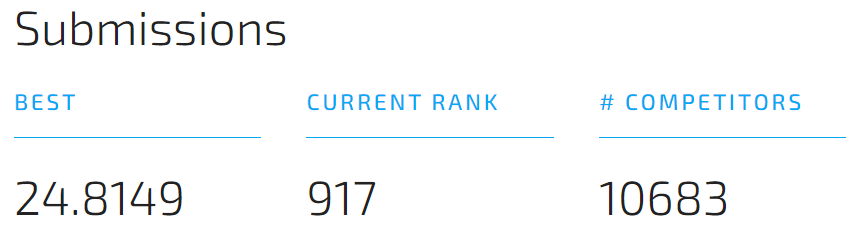